In [1]:
import numpy as np

In [2]:
np.random.seed(42 + 7 + 4)

In [3]:
import scipy.stats

Читал книгу Маленький Трактат о случае и случайностях Юбера Кривина.

И натолкнул меня один пример на осознание простого факта: частотная оценка вероянтности у нас работает только для оценки вероятности события по i.i.d. выборке.
    
Захотелось построить модель, где частотная оценка будет некорректной.

Результатом хочется поделиться.

Придумалось следующее: давайте оценим верятность той оценки, которую ученик получит на выпускном экзамене.

При этом оценка за четверть последнюю у нас уже есть, т.е. мы знаем, кто двоечник, кто троечник, кто хорошист и кто отличник.

Какова вероятность, что ученик получит оценку 4 ?

Распределение оценок у нас будет смесью оценок отличников, хорошистов, троечников и двоечников.
  
Примем модель, что score, который показывает ученик на выпускном экзамене это будет нормально распределённая величина с sigma = 1/2 и средними 5,4,3,2 соответственно.

Далее, по порогам (2.5, 3.5, 4.5) переводим score в отметку.

Мотивировка к тому, как распредеить доли учеников по уровню их знаний (эта модель -- свобоный параметр нашей конструкции, можете заменить на свою):

Пусть у нас хорошо откалиброванные задания. И методика преподавания такова, что доли студентов с разными знаниями по популяции у нас будут связаны тоже с "колоколом" нормального распределения.

Пороги выберем такие: (-3 сигма, -1 сигма, 1 сигма).

Они позволят нам оценить число двоечников, троечников, хорошистов и отличников.


In [4]:
p_2 = scipy.stats.norm.cdf(-3)
print(p_2.round(4))

0.0013


In [5]:
p_3 = scipy.stats.norm.cdf(-1) - scipy.stats.norm.cdf(-3)
print(p_3.round(4))

0.1573


In [6]:
p_4 = scipy.stats.norm.cdf(1) - scipy.stats.norm.cdf(-1)
print(p_4.round(4))

0.6827


In [7]:
p_5 = 1 - scipy.stats.norm.cdf(1) 
print(p_5.round(4))

0.1587


Пусть у нас есть 3 класса  по 30 человек в 50 школах, т.е. всего 4500 учеников.

Распределим их по уровню усвоения материала:

In [8]:
draw = np.random.choice([2,3,4,5], 30 * 3 * 50,
              p=[p_2, p_3, p_4, p_5])

In [9]:
import matplotlib.pyplot as plt

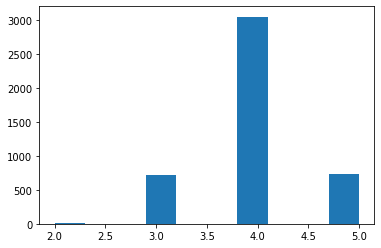

In [10]:
plt.hist(draw)
plt.show()

In [11]:
import pandas as pd

In [12]:
marks = pd.Series(draw).value_counts()

In [13]:
marks[2], marks[3], marks[4], marks[5], marks.sum()

(6, 714, 3048, 732, 4500)

Разыграем согласно обозначенной модели, качство выполнения экзаменационной работы:

In [14]:
quality_2 = scipy.random.normal(loc=2, scale=0.5, size=marks[2])

In [15]:
quality_3 = scipy.random.normal(loc=3, scale=0.5, size=marks[3])

In [16]:
quality_4 = scipy.random.normal(loc=4, scale=0.5, size=marks[4])

In [17]:
quality_5 = scipy.random.normal(loc=5, scale=0.5, size=marks[5])

In [18]:
quality_scores = np.hstack([quality_2, quality_3, quality_4, quality_5])

(array([  27.,  124.,  292.,  673., 1144., 1104.,  667.,  325.,  124.,
          20.]),
 array([1.57925667, 2.06113337, 2.54301006, 3.02488676, 3.50676345,
        3.98864015, 4.47051684, 4.95239353, 5.43427023, 5.91614692,
        6.39802362]),
 <BarContainer object of 10 artists>)

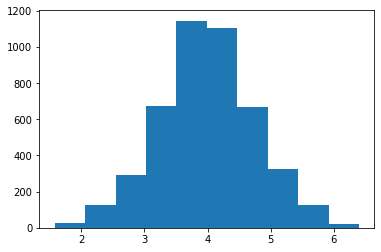

In [19]:
plt.hist(quality_scores)

Вычислим, сколько у нас каких оценок получилось, указывая при этом, сколько было учеников с уровнем заний, совпадащим с оценкой:

In [20]:
(quality_scores < 2.5).sum(), marks[2]

(131, 6)

In [21]:
((quality_scores >=  2.5) & (quality_scores <  3.5)).sum(), marks[3]

(973, 714)

In [22]:
((quality_scores >=  3.5) & (quality_scores <  4.5)).sum(), marks[4]

(2315, 3048)

In [23]:
((quality_scores >= 4.5)).sum(), marks[5]

(1081, 732)

mark -- оценка
score -- качество решения проверочной работы

Вычислим теоретические вероятности получить оценку mark, при уровне ученика student_level, согласно нашей модели

In [24]:
import collections

In [25]:

p_mark_x_stu_y = collections.defaultdict(dict)

for i_mark, mark in enumerate([2,3,4,5]):
    for i_student_level, student_level in enumerate([2,3,4,5]):
        loc = mark - student_level
        
        if mark == 5:
            high_q = np.inf
        else:
            high_q = 0.5 + loc
        
        if mark == 2:
            low_q = -np.inf
        else:
            low_q = -0.5 + loc
        
        p = scipy.stats.norm.cdf(high_q) - scipy.stats.norm.cdf(low_q)
        p_mark_x_stu_y[mark][student_level] = p
        print(f"P(Mark = {mark} | student_level = {student_level}) = {p}")
        print(f"low_q {low_q}, high_q {high_q}")
        


P(Mark = 2 | student_level = 2) = 0.6914624612740131
low_q -inf, high_q 0.5
P(Mark = 2 | student_level = 3) = 0.3085375387259869
low_q -inf, high_q -0.5
P(Mark = 2 | student_level = 4) = 0.06680720126885807
low_q -inf, high_q -1.5
P(Mark = 2 | student_level = 5) = 0.006209665325776132
low_q -inf, high_q -2.5
P(Mark = 3 | student_level = 2) = 0.2417303374571288
low_q 0.5, high_q 1.5
P(Mark = 3 | student_level = 3) = 0.38292492254802624
low_q -0.5, high_q 0.5
P(Mark = 3 | student_level = 4) = 0.2417303374571288
low_q -1.5, high_q -0.5
P(Mark = 3 | student_level = 5) = 0.06059753594308194
low_q -2.5, high_q -1.5
P(Mark = 4 | student_level = 2) = 0.060597535943081926
low_q 1.5, high_q 2.5
P(Mark = 4 | student_level = 3) = 0.2417303374571288
low_q 0.5, high_q 1.5
P(Mark = 4 | student_level = 4) = 0.38292492254802624
low_q -0.5, high_q 0.5
P(Mark = 4 | student_level = 5) = 0.2417303374571288
low_q -1.5, high_q -0.5
P(Mark = 5 | student_level = 2) = 0.006209665325776159
low_q 2.5, high_q inf


Самопроверка:

In [26]:
 p_mark_x_stu_y[2][2] +  p_mark_x_stu_y[3][2] +  p_mark_x_stu_y[4][2] +  p_mark_x_stu_y[5][2]

1.0

In [27]:
 p_mark_x_stu_y[2][3] +  p_mark_x_stu_y[3][3] +  p_mark_x_stu_y[4][3] +  p_mark_x_stu_y[5][3]

1.0

In [28]:
 p_mark_x_stu_y[2][4] +  p_mark_x_stu_y[3][4] +  p_mark_x_stu_y[4][4] +  p_mark_x_stu_y[5][4]

1.0

In [29]:
 p_mark_x_stu_y[2][5] +  p_mark_x_stu_y[3][5] +  p_mark_x_stu_y[4][5] +  p_mark_x_stu_y[5][5]

1.0

Теперь, вычислим теоретические вероятность у случайного ученика получить оценку 4.
Вычислим это по формуле полной вреноятности.

In [30]:
p_mark_x_theory = {}
for x in [2,3,4,5]:
    p_mark_x_theory[x] = p_mark_x_stu_y[x][2] * p_2 
    p_mark_x_theory[x] += p_mark_x_stu_y[x][3] * p_3
    p_mark_x_theory[x] += p_mark_x_stu_y[x][4] * p_4
    p_mark_x_theory[x] += p_mark_x_stu_y[x][5] * p_5
    

In [31]:
p_mark_x_theory

{2: 0.09606178148759507,
 3: 0.2352033312964535,
 4: 0.33787788623311266,
 5: 0.3308570009828387}

Получим частотные оценки вероятности у случайного ученика получить оценку 4:

In [32]:
freq_mark_x = {
    2: (quality_scores <  2.5).sum() / 4500,
    3: ((quality_scores >=  2.5) & (quality_scores <  3.5)).sum() / 4500,
    4: ((quality_scores >=  3.5) & (quality_scores <  4.5)).sum() / 4500,
    5: (quality_scores >=  4.5).sum() / 4500
}

In [33]:
freq_mark_x

{2: 0.029111111111111112,
 3: 0.21622222222222223,
 4: 0.5144444444444445,
 5: 0.24022222222222223}

Text(0, 0.5, 'Теоретическое значение из модели')

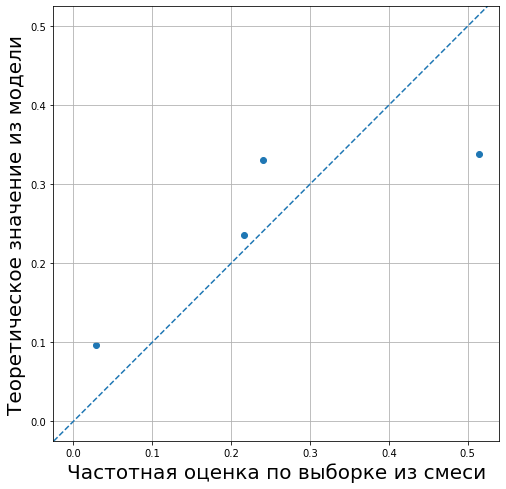

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(freq_mark_x.values(), p_mark_x_theory.values())
plt.axline((0, 0), (0.5, 0.5), linestyle="--")
plt.grid(True)
plt.xlabel("Частотная оценка по выборке из смеси", size=20)
plt.ylabel("Теоретическое значение из модели", size=20)

У нас получилась заниженной частотная оценка получения оценки отлично, и завышенными частотные оценки остальных оценок.


Теперь всё в одну функцию сведём, чтобы оценить разброс.

In [35]:
import argparse

In [36]:
def _get_student_levels_shares():
    p_2 = scipy.stats.norm.cdf(-3)
    p_3 = scipy.stats.norm.cdf(-1) - scipy.stats.norm.cdf(-3)
    p_4 = scipy.stats.norm.cdf(1) - scipy.stats.norm.cdf(-1)
    p_5 = 1 - scipy.stats.norm.cdf(1) 
    
    return {2: p_2, 3: p_3, 4: p_4, 5: p_5}





def _simulate_students_levels(n_students, student_levels_shares):
    p = student_levels_shares
    
    draw = np.random.choice([2,3,4,5], n_students,
              p=[p[2], p[3], p[4], p[5]])
    return draw
    

def _aggregate_student_levels(student_levels):
    marks = pd.Series(student_levels).value_counts()
    return marks


def _simulate_scores(mark_2_n_students):
    students_at_level_x_2_scores = {}
    for student_level in [2, 3, 4, 5]:
        students_at_level_x_2_scores[student_level] = \
        scipy.random.normal(
            loc=student_level, 
            scale=0.5, 
            size=mark_2_n_students[student_level]
        )
    scores = np.hstack(list(students_at_level_x_2_scores.values()))
    
    return scores



def _eval_theoretical_probs():
    p_mark_x_stu_y = collections.defaultdict(dict)

    for mark in [2,3,4,5]:
        for student_level in [2,3,4,5]:
            loc = mark - student_level

            if mark == 5:
                high_q = np.inf
            else:
                high_q = 0.5 + loc

            if mark == 2:
                low_q = -np.inf
            else:
                low_q = -0.5 + loc

            p = scipy.stats.norm.cdf(high_q) - scipy.stats.norm.cdf(low_q)
            p_mark_x_stu_y[mark][student_level] = p
    
    return p_mark_x_stu_y





def _eval_theoretical_probs_of_mark_x(p_mark_x_stu_y, student_levels_shares):
    p = student_levels_shares
    p_mark_x_theory = {}
    for x in [2,3,4,5]:
        p_mark_x_theory[x] = p_mark_x_stu_y[x][2] * p[2] 
        p_mark_x_theory[x] += p_mark_x_stu_y[x][3] * p[3]
        p_mark_x_theory[x] += p_mark_x_stu_y[x][4] * p[4]
        p_mark_x_theory[x] += p_mark_x_stu_y[x][5] * p[5]
    return p_mark_x_theory




def _eval_estimates_from_sumulated_scores(quality_scores, n_students):
    freq_mark_x = {
        2: (quality_scores <  2.5).sum() / n_students,
        3: ((quality_scores >=  2.5) & (quality_scores <  3.5)).sum() / n_students,
        4: ((quality_scores >=  3.5) & (quality_scores <  4.5)).sum() / n_students,
        5: (quality_scores >=  4.5).sum() / n_students
    }
    
    return freq_mark_x

    
def do_simulation(n_students, student_levels_shares):
    
    student_levels = _simulate_students_levels(n_students=n_students, student_levels_shares=student_levels_shares)
    
    mark_2_n_students = _aggregate_student_levels(student_levels=student_levels)
    
    scores = _simulate_scores(mark_2_n_students=mark_2_n_students)
    
    freq_mark_x = _eval_estimates_from_sumulated_scores(quality_scores=scores, n_students=n_students)
   
    return freq_mark_x

In [37]:
%%time
np.random.seed(42 + 7 + 4)

n_students = 1_000_000

student_levels_shares = _get_student_levels_shares()
p_mark_x_stu_y = _eval_theoretical_probs()


p_mark_x_theory = _eval_theoretical_probs_of_mark_x(p_mark_x_stu_y=p_mark_x_stu_y, student_levels_shares=student_levels_shares)

freq_mark_x_list = []
for _ in range(1000):
    freq_mark_x = do_simulation(n_students = n_students, student_levels_shares=student_levels_shares)
    freq_mark_x_list.append(freq_mark_x)

CPU times: user 51.8 s, sys: 4.48 s, total: 56.3 s
Wall time: 56.3 s


Text(0, 0.5, 'Теоретическое значение из модели')

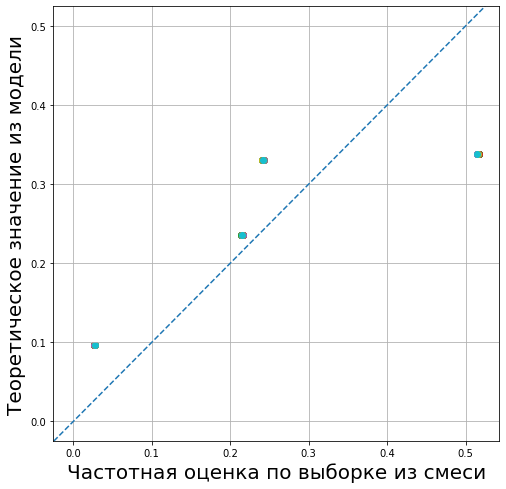

In [38]:
plt.figure(figsize=(8, 8))
for freq_mark_x in freq_mark_x_list:
    plt.scatter(freq_mark_x.values(), p_mark_x_theory.values())
plt.axline((0, 0), (0.5, 0.5), linestyle="--")
plt.grid(True)
plt.xlabel("Частотная оценка по выборке из смеси", size=20)
plt.ylabel("Теоретическое значение из модели", size=20)

Видим, что при увеличении числа учеников с 4_500 до 1_000_000 и при 1000 симуляциях оценок (при заданном распределнии student_levels_shares), выводы остаются верными.

теперь еще и _get_student_levels_shares несколько разыграем.

In [39]:
import tqdm

100%|██████████| 10/10 [02:53<00:00, 17.32s/it]

CPU times: user 2min 51s, sys: 1.31 s, total: 2min 53s
Wall time: 2min 53s


Text(0, 0.5, 'Теоретическое значение из модели')

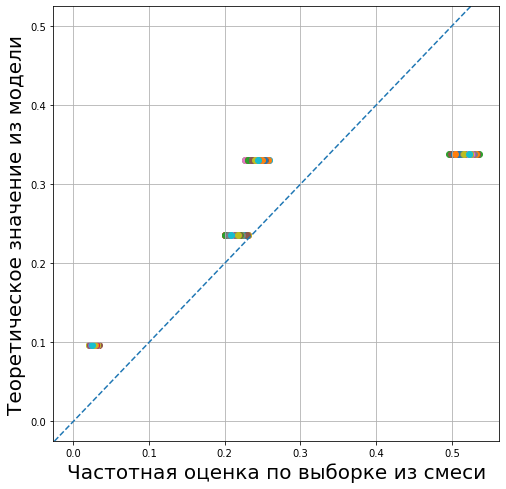

In [40]:
%%time
np.random.seed(42 + 7 + 4)

n_students = 10_000


plt.figure(figsize=(8, 8))

for i in tqdm.tqdm(range(10)):

    student_levels_shares = _get_student_levels_shares()
    p_mark_x_stu_y = _eval_theoretical_probs()


    p_mark_x_theory = _eval_theoretical_probs_of_mark_x(p_mark_x_stu_y=p_mark_x_stu_y, student_levels_shares=student_levels_shares)
    
    freq_mark_x_list = []
    for _ in range(1000):
        freq_mark_x = do_simulation(n_students = n_students, student_levels_shares=student_levels_shares)
        freq_mark_x_list.append(freq_mark_x)
        
    
    for freq_mark_x in freq_mark_x_list:
        plt.scatter(freq_mark_x.values(), p_mark_x_theory.values())
    
plt.axline((0, 0), (0.5, 0.5), linestyle="--")
plt.grid(True)
plt.xlabel("Частотная оценка по выборке из смеси", size=20)
plt.ylabel("Теоретическое значение из модели", size=20)


Видим, что и при увеличении числа учеников с 4_500 до 10_000 и при 1000 симуляциях оценок (для 10 разных student_levels_shares), выводы остаются верными.